# LangGraph Introduction

Traditional applications using LLMs were using a chain approach using LangChain. While chains are reliable, they are not flexible. They cannot adapt their flow based on the content being processed or make autonomous decisions about the next steps. Agents can decide their own sequence of steps based on the input they receive. This means agents can choose dynamic routing, can decide which tools or APIs to call based on the task at hand, can adapt responses.

## Overview of LangGraph

LangGraph is an open-source framework to simplify development of AI agents. LangGraph structures workflows as graphs. In LangGraph workflow, tasks or actions are repesented as **nodes** and the connection between each node is represented as **edges**. Each node can perform a specific function like data processing or decision making. Edges can be configured with conditions to follow different paths based on specific criteria.

### Principles of LangGraph
LangGraph is built on few principles as mentioned below.
1. You can define your application flow using nodes and edges which can be deterministic.
2. You can maintain the state of the application across different sessions using storage options.
3. You also incorporate human-in-the-loop pattern to get feedback from users.
4. You also have the flexibility to provide real-time updates

AI agents are used for multiple real-world applications ranging from customer service, healthcare to analyze patient data and monitoring health, monitor market trends, recommendation systems, etc.

Let's build first LangGraph agent.

## Hello World in LangGraph

As mentioned previously, LangGraph agents are built using nodes and edges. There is third component **states** which is used to store and pass data between nodes. This is the way each node maintains context throughout the workflow. In LangGraph, a state represents the application's current data. It is usually defined with `TypedDict` or Pydantic `BaseModel` for ensuring data consistency.

In [1]:
from typing_extensions import TypedDict
class HelloWorldState(TypedDict):
    greeting: str # The key that will store the greeting

Next, you can define a node that will process the incoming data through state and updates the state. Each node in your LangGraph workflow has access to the state which allows it to read and modify data as needed.

In [3]:
def first_node(state: HelloWorldState):
    state['greeting'] = f"Hello, {state['greeting']}"
    return state

Next, you can define the graph to connect each of the nodes. Here, you create the `StateGraph` with `HelloWorldState` schema. The graph will not exxpect data structured based on this `HelloWorldState` class. You use `add_node()` function to add a new node with label 'greet'. You use `add_edge()` function to connect `START` and `END` nodes.

In [4]:
from langgraph.graph import StateGraph, START, END

builder = StateGraph(HelloWorldState)
builder.add_node("greet", first_node) # Add node
# Connect edges
builder.add_edge(START, "greet")
builder.add_edge("greet", END)

Next, once the graph is configured, you can compile it and run the workflow by invoking the graph with `invoke()` function.

In [6]:
graph = builder.compile()
result = graph.invoke({"greeting": "LangGraph"})

In [7]:
print(result)

{'greeting': 'Hello, LangGraph'}


When invoking this graph, you pass the initial state in the same schemas the `HelloWorldState` defined for the graph.

### Visualize Graph

You can also create PNG visualization of the graph to better understand the flow of the graph.

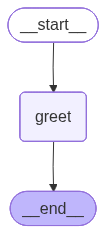

In [8]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

## Adding new Node in Graph

If you want to add one more node, you can simply add it like below.

In [9]:
def hi(state: HelloWorldState):
    state['greeting'] = state['greeting'].replace('Hello', 'Hi')
    return state

In [11]:
builder.add_edge(START, 'greet')
builder.add_node('update_greeting', hi)
builder.add_edge('greet', 'update_greeting')
builder.add_edge('update_greeting', END)

graph = builder.compile()
result = graph.invoke({'greeting': 'LangGraph'})
print(result)

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.
Adding a node to a graph that has already been compiled. This will not be reflected in the compiled graph.
Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.
Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


{'greeting': 'Hi, LangGraph'}


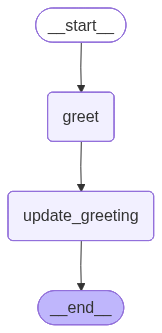

In [12]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

## Key Concepts

LangGraph revolves around graphs with connected tasks that can be used to build workflows for AI agents.

### State
The state is a shared data structure to store information as it flows through the nodes in a graph. It allows different parts of the workflow to share information across multiple nodes. In LangGraph, states are usually Python dictionaries, `TypedDict` or Pydantic models. The data can be modified by other nodes in the workflow.

```python
from typing_extensions import TypedDict

class HelloWorldState(TypedDict):
    message: str
```

Here, `HelloWorldState` class defines a state that can store a string message. 

### Nodes

A node is responsible for executing a specific task. Nodes represent each action or a decision point in a workflow. Nodes are implemented as Python functions that accept a state and return a modified version of the state.

```python
def hello_world(state: HelloWorldState):
    state['message'] = "Hello there"
    return state
```

When you break workflows into smaller steps, you can build more complex functionality.
Nodes can be added to existing graph using `add_node` function.

```python
graph_builder.add_node("hello", hello_world)
```

### Edges

Edges define the connections between nodes and control how data flows from one node to the next and also determines the order in which tasks are executed. Edges are the arrows in the graph that show the path from one node to another in a workflow.

```python
graph_builder = StateGraph(HelloWorldState)

graph_builder.add_edge('raise_invoce', raise_invoice)
graph_builder.add_edge('receive_payment', END)
```

The **starting node** marks the entry point of the graph and activates the execution of the graph. In LangGraph, the start of a workflow is denoted by constant `START`.

```python
graph_builder.add_edge(START, 'hello')
```

Alternatively, you can add entry point using `set_entry_point` function.

```python
graph_builder.set_entry_point('hello')
```

The **end node** represents the end of the workflow and indicates the workflow has reached its final task. The end node is represented by a constant `END` in LangGraph.

```python
graph_builder.add_edge('goodbye', END)
```

Alternatively, you can use `set_finish_point` to define the last node.

```python
graph_builder.set_finish_point('goodbye')
```

**Conditional edges** allow the workflow to branch out based on defined conditions. With this, you can define different paths that the workflow might take depending on the state of the data or the outcome of a node. For example, depending on user subscription, you want to pass the request to higher model or less powerful LLM model.

```python
def check_user_subscription(state: UserState):
    if state['is_premium']:
        return 'premium_service'
    else:
        return 'regular_service'

graph_builder.add_conditional_edges('provide_answer', check_user_subscription)
```

You can define different types of logic and flow of your workflow.
- Edges ensure that the tasks are executed in correct order.
- Conditional edges enable branching logic based on conditions or data.
- End nodes define the end point of the graph
- Edges can be designed to handle errors, guiding the workflow to recover when unexpected outcomes occur.

In [5]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END

# Define the state for user data
class UserState(TypedDict):
    is_premium: bool
    message: str

# Define nodes 
def greet_user(state: UserState):
    state['message'] = 'Welcome!'
    return state

def premium_greeting(state: UserState):
    state['message'] += " Thank you for using our premium services"
    return state

def regular_greeting(state: UserState):
    state['message'] += " Enjoy our free services"
    return state

# Define decision node
def check_user_subscription(state: UserState):
    if state['is_premium']:
        return "premium_greeting"
    else:
        return "regular_greeting"

# Build the graph
graph_builder = StateGraph(UserState)
graph_builder.add_node('greet_user', greet_user)
graph_builder.add_node('check_subscription', check_user_subscription)
graph_builder.add_node('premium_greeting', premium_greeting)
graph_builder.add_node('regular_greeting', regular_greeting)

graph_builder.add_edge(START, 'greet_user')
graph_builder.add_conditional_edges('greet_user', check_user_subscription)
graph_builder.add_edge('premium_greeting', END)
graph_builder.add_edge('regular_greeting', END)

# Compile the graph
graph = graph_builder.compile()
result = graph.invoke({'is_premium': True, 'message': ""})
print(result)

{'is_premium': True, 'message': 'Welcome! Thank you for using our premium services'}


In [6]:
result = graph.invoke({'is_premium': False, 'message': ""})
print(result)

{'is_premium': False, 'message': 'Welcome! Enjoy our free services'}


## Graph

A graph in LangGraph is a structure that brings nodes, edges and states together into a coherent workflow. It serves as a blueprint for agent's activities and defines how information flows through the entire process. A graph provides a framework within which nodes operate with edges guiding the flow of the state through the connected tasks.

### Types of Graphs

1. **StateGraph** class is the main graph class which is parameterized by a user defined `State` object.
2. **MessageGraph** class is a special type of graph made for handling a list of messages suited for a chat application. The state of a `MessageGraph` is ONLY as list of messages. Most applications require the State toe be more complex than a list of messages, so this is rarely used.

Once you've defined the graph nodes and edges, you can compile the graph builder into a graph. It does the following.
1. Checks and validates the structure of the graph to make sure all nodes are completely utilized within the edges and all edges are correctly defining a complete workflow.
2. specifies memory arguments like checkpointers.
3. Defines breakpoints for human in the loop intervention actions.

Nodes usually communicate with a single schema. When you debug a LangGraph workflow, you can see the actual values of the variables in your workflow.

## Input and Output Schemas 

LangGraph allows for different input and output schemas, providing flexibility to enable developers to use different subsets of data for different parts of the graph. Nodes can communicate using private (internal) or external (output) states.

In LangGraph workflow, input and output schemas define the structure of data entering and exiting nodes. With this, you can control which data gets passed between nodes and how the final results are returned.

`OverallState` below contains all the data relevant to the graph. `InputState` is a simplified version of `OverallState` that only includes the user input. `OutputState` is another subset that only contains the final message output.

In [7]:
from typing_extensions import TypedDict

class OverallState(TypedDict):
    partial_message: str
    user_input: str
    message_output: str

class InputState(TypedDict):
    user_input: str

class OutputState(TypedDict):
    message_output: str

class PrivateState(TypedDict):
    private_message: str

Nodes can work with different subsets of the data.

In [9]:
def add_world(state: InputState) -> OutputState:
    partial_message = state['user_input'] + " World"
    return {'partial_message': partial_message, 'user_input': state['user_input'], 'message_output': ""}

def add_exclamation(state: OverallState) -> PrivateState:
    private_message = state['partial_message'] + "!"
    return {'private_message': private_message}

def finalize_message(state: PrivateState) -> OutputState:
    message_output = state['private_message']
    return {'message_output': message_output}

builder = StateGraph(OverallState, input=InputState, output=OutputState)
builder.add_node('add_world', add_world)
builder.add_node('add_exclamation', add_exclamation)
builder.add_node('finalize_message', finalize_message)

builder.add_edge(START, 'add_world')
builder.add_edge('add_world', 'add_exclamation')
builder.add_edge('add_exclamation', 'finalize_message')
builder.add_edge('finalize_message', END)

graph = builder.compile()
result = graph.invoke({'user_input': "Hello"})
print(result)

{'message_output': 'Hello World!'}


/tmp/ipykernel_182/3928217914.py:13: LangGraphDeprecatedSinceV05: `input` is deprecated and will be removed. Please use `input_schema` instead. Deprecated in LangGraph V0.5 to be removed in V2.0.
  builder = StateGraph(OverallState, input=InputState, output=OutputState)
/tmp/ipykernel_182/3928217914.py:13: LangGraphDeprecatedSinceV05: `output` is deprecated and will be removed. Please use `output_schema` instead. Deprecated in LangGraph V0.5 to be removed in V2.0.
  builder = StateGraph(OverallState, input=InputState, output=OutputState)


`InputState` is passed to the first node to process user input. `OverallState` is used internally by `add_world` and `add_exclamation` to manage and manipulate intermediate data. `PrivateState` is used as an internal communication channel between `add_exclamation` and `finalize_message`, allowing the final node ot access transformed data without exposing it to the rest of the graph. `OutputState` is returned by the `finalize_message` node containing the result of the workflow.

A super-step is like a round or phase where certain nodes in the graph execute together. If nodes can run simultaneously, they belong to the same super-step. During a super-step, all nodes that have received messages work at the same time. Each runs its function and sends out updates or results. At the end of a super-step, the graph checks if there are any nodes that didn't receive new messages. These nodes then go back to being inactive.

Let's see an example of Conditional logic where based on the input from user, it will respond with different greetings.

In [12]:
from typing_extensions import TypedDict

class GreetingState(TypedDict):
    greeting: str

def normalize_greeting_node(state):
    state['greeting'] = state['greeting'].lower()
    return state

def hi_greeting_node(state):
    state['greeting'] = "Hi there, How are you doing?"
    return state

def regular_greeting_node(state):
    state['greeting'] = "Hello, " + state['greeting']
    return state

def choose_greeting_node(state):
    return "hi_greeting" if "hi" in state['greeting'] else "regular_greeting"

builder = StateGraph(GreetingState)
builder.add_node("normalize_greeting", normalize_greeting_node)
builder.add_node("hi_greeting", hi_greeting_node)
builder.add_node("regular_greeting", regular_greeting_node)

builder.add_edge(START, "normalize_greeting")
builder.add_conditional_edges("normalize_greeting", choose_greeting_node, ["hi_greeting", "regular_greeting"])
builder.add_edge("hi_greeting", END)
builder.add_edge("regular_greeting", END)

graph = builder.compile()
result = graph.invoke({"greeting": "Hi There!"})
print(result)

{'greeting': 'Hi there, How are you doing?'}


In [13]:
result = graph.invoke({'greeting': "Good morning!"})
print(result)

{'greeting': 'Hello, good morning!'}
